In [104]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [105]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"] # "Product_Category_B", "Region"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [106]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates, axis = 1)
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    #data = data.drop_duplicates([x for x in data.columns if x != 'ID'])
    
    return (data)

In [107]:
import catboost as ctb

In [108]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [109]:
rest = [x for x in data.columns if x != 'ID']
len(data[data.duplicated(rest)])/float(len(data)) * 100

2.643535729037588

In [110]:
prep = preprocess(data)

In [111]:
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [112]:
len(prep[prep.duplicated()])

481

In [140]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=42)

In [141]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [115]:
cat_vars

['Region',
 'Territory',
 'Bureaucratic_Code',
 'Source',
 'Billing_Country',
 'Account_Owner',
 'Opportunity_Owner',
 'Currency',
 'Last_Modified_By',
 'Delivery_Quarter']

In [142]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [117]:
cat_indexes

[0, 1, 6, 7, 8, 9, 10, 11, 12, 15]

In [143]:
params = {u'auto_class_weights': u'None',
# u'bayesian_matrix_reg': 0.10000000149011612,
 u'best_model_min_trees': 1,
 u'boost_from_average': False,
 u'boosting_type': u'Plain',
 u'bootstrap_type': u'MVS',
 u'border_count': 400,
 u'class_names': [0, 1],
 u'classes_count': 0,
 u'combinations_ctr': [u'Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  u'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 u'counter_calc_method': u'SkipTest',
 u'ctr_leaf_count_limit': 18446744073709551615L,
 u'ctr_target_border_count': 1,
 u'depth': 8,
 u'eval_metric': u'Logloss',
 u'feature_border_type': u'GreedyLogSum',
 u'fold_permutation_block': 0,
 u'grow_policy': u'SymmetricTree',
 u'has_time': False,
 u'iterations': 500,
 u'l2_leaf_reg': 7,
 u'leaf_estimation_backtracking': u'AnyImprovement',
 u'leaf_estimation_iterations': 10,
 u'leaf_estimation_method': u'Newton',
 u'learning_rate': 0.5,
 u'loss_function': u'Logloss',
 u'max_ctr_complexity': 4,
 u'max_leaves': 31,
 u'min_data_in_leaf': 1,
 u'model_shrink_mode': u'Constant',
 u'model_shrink_rate': 0,
 u'model_size_reg': 0.5,
 u'nan_mode': u'Min',
 u'one_hot_max_size': 2,
 u'penalties_coefficient': 1,
 #u'permutation_count': 4,
 u'random_seed': 42,
 u'random_strength': 1,
 u'rsm': 0.9800000190734864,
 u'sampling_frequency': u'PerTree',
 u'score_function': u'Cosine',
 u'simple_ctr': [u'Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  u'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 u'sparse_features_conflict_fraction': 0,
 u'store_all_simple_ctr': False,
 u'subsample': 0.800000011920929,
 u'task_type': u'CPU',
 u'use_best_model': True}

In [144]:
model = ctb.CatBoostClassifier(**params)

In [145]:
model.fit(X=prep.drop(target, axis=1), y=prep.Stage, eval_set=(x_test.drop(target, axis=1), y_test), cat_features=cat_indexes)

0:	learn: 0.2130344	test: 0.2118097	best: 0.2118097 (0)	total: 20.1ms	remaining: 10s
1:	learn: 0.1325442	test: 0.1313557	best: 0.1313557 (1)	total: 41.9ms	remaining: 10.4s
2:	learn: 0.1143017	test: 0.1128146	best: 0.1128146 (2)	total: 62.6ms	remaining: 10.4s
3:	learn: 0.1037859	test: 0.1020311	best: 0.1020311 (3)	total: 84.6ms	remaining: 10.5s
4:	learn: 0.0978888	test: 0.0968181	best: 0.0968181 (4)	total: 104ms	remaining: 10.3s
5:	learn: 0.0933928	test: 0.0926575	best: 0.0926575 (5)	total: 124ms	remaining: 10.2s
6:	learn: 0.0882303	test: 0.0891764	best: 0.0891764 (6)	total: 144ms	remaining: 10.1s
7:	learn: 0.0824523	test: 0.0844477	best: 0.0844477 (7)	total: 164ms	remaining: 10.1s
8:	learn: 0.0799880	test: 0.0818332	best: 0.0818332 (8)	total: 183ms	remaining: 10s
9:	learn: 0.0767893	test: 0.0791232	best: 0.0791232 (9)	total: 205ms	remaining: 10.1s
10:	learn: 0.0719721	test: 0.0745581	best: 0.0745581 (10)	total: 228ms	remaining: 10.1s
11:	learn: 0.0719719	test: 0.0745574	best: 0.0745574

94:	learn: 0.0214097	test: 0.0281964	best: 0.0281964 (94)	total: 2.13s	remaining: 9.08s
95:	learn: 0.0213373	test: 0.0281558	best: 0.0281558 (95)	total: 2.16s	remaining: 9.11s
96:	learn: 0.0211280	test: 0.0279402	best: 0.0279402 (96)	total: 2.19s	remaining: 9.09s
97:	learn: 0.0211279	test: 0.0279401	best: 0.0279401 (97)	total: 2.22s	remaining: 9.11s
98:	learn: 0.0211279	test: 0.0279401	best: 0.0279401 (97)	total: 2.24s	remaining: 9.07s
99:	learn: 0.0209658	test: 0.0279141	best: 0.0279141 (99)	total: 2.26s	remaining: 9.06s
100:	learn: 0.0209657	test: 0.0279140	best: 0.0279140 (100)	total: 2.28s	remaining: 9.02s
101:	learn: 0.0209657	test: 0.0279140	best: 0.0279140 (101)	total: 2.3s	remaining: 8.98s
102:	learn: 0.0209437	test: 0.0279049	best: 0.0279049 (102)	total: 2.32s	remaining: 8.96s
103:	learn: 0.0209436	test: 0.0279047	best: 0.0279047 (103)	total: 2.35s	remaining: 8.95s
104:	learn: 0.0205632	test: 0.0276205	best: 0.0276205 (104)	total: 2.38s	remaining: 8.94s
105:	learn: 0.0205631	t

190:	learn: 0.0121907	test: 0.0200593	best: 0.0200593 (190)	total: 4.46s	remaining: 7.22s
191:	learn: 0.0121907	test: 0.0200580	best: 0.0200580 (191)	total: 4.48s	remaining: 7.19s
192:	learn: 0.0121113	test: 0.0199560	best: 0.0199560 (192)	total: 4.51s	remaining: 7.17s
193:	learn: 0.0121112	test: 0.0199560	best: 0.0199560 (192)	total: 4.54s	remaining: 7.16s
194:	learn: 0.0121112	test: 0.0199563	best: 0.0199560 (192)	total: 4.56s	remaining: 7.14s
195:	learn: 0.0121112	test: 0.0199564	best: 0.0199560 (192)	total: 4.58s	remaining: 7.11s
196:	learn: 0.0118991	test: 0.0197672	best: 0.0197672 (196)	total: 4.61s	remaining: 7.09s
197:	learn: 0.0115609	test: 0.0193685	best: 0.0193685 (197)	total: 4.64s	remaining: 7.08s
198:	learn: 0.0114574	test: 0.0192904	best: 0.0192904 (198)	total: 4.67s	remaining: 7.06s
199:	learn: 0.0113736	test: 0.0192516	best: 0.0192516 (199)	total: 4.69s	remaining: 7.04s
200:	learn: 0.0113736	test: 0.0192517	best: 0.0192516 (199)	total: 4.71s	remaining: 7.01s
201:	learn

286:	learn: 0.0096701	test: 0.0174669	best: 0.0173416 (260)	total: 6.54s	remaining: 4.85s
287:	learn: 0.0096701	test: 0.0174668	best: 0.0173416 (260)	total: 6.55s	remaining: 4.82s
288:	learn: 0.0096701	test: 0.0174668	best: 0.0173416 (260)	total: 6.57s	remaining: 4.79s
289:	learn: 0.0096701	test: 0.0174668	best: 0.0173416 (260)	total: 6.58s	remaining: 4.77s
290:	learn: 0.0095751	test: 0.0173592	best: 0.0173416 (260)	total: 6.61s	remaining: 4.74s
291:	learn: 0.0095751	test: 0.0173592	best: 0.0173416 (260)	total: 6.63s	remaining: 4.72s
292:	learn: 0.0095751	test: 0.0173592	best: 0.0173416 (260)	total: 6.64s	remaining: 4.69s
293:	learn: 0.0095751	test: 0.0173593	best: 0.0173416 (260)	total: 6.66s	remaining: 4.67s
294:	learn: 0.0095750	test: 0.0173593	best: 0.0173416 (260)	total: 6.68s	remaining: 4.64s
295:	learn: 0.0095750	test: 0.0173593	best: 0.0173416 (260)	total: 6.7s	remaining: 4.61s
296:	learn: 0.0095749	test: 0.0173597	best: 0.0173416 (260)	total: 6.71s	remaining: 4.59s
297:	learn:

384:	learn: 0.0082396	test: 0.0167534	best: 0.0165958 (375)	total: 8.4s	remaining: 2.51s
385:	learn: 0.0082396	test: 0.0167534	best: 0.0165958 (375)	total: 8.43s	remaining: 2.49s
386:	learn: 0.0081519	test: 0.0166477	best: 0.0165958 (375)	total: 8.45s	remaining: 2.47s
387:	learn: 0.0081501	test: 0.0166482	best: 0.0165958 (375)	total: 8.47s	remaining: 2.44s
388:	learn: 0.0080987	test: 0.0166519	best: 0.0165958 (375)	total: 8.49s	remaining: 2.42s
389:	learn: 0.0080986	test: 0.0166517	best: 0.0165958 (375)	total: 8.52s	remaining: 2.4s
390:	learn: 0.0080986	test: 0.0166518	best: 0.0165958 (375)	total: 8.54s	remaining: 2.38s
391:	learn: 0.0080100	test: 0.0164470	best: 0.0164470 (391)	total: 8.56s	remaining: 2.36s
392:	learn: 0.0080100	test: 0.0164466	best: 0.0164466 (392)	total: 8.57s	remaining: 2.33s
393:	learn: 0.0079567	test: 0.0164569	best: 0.0164466 (392)	total: 8.59s	remaining: 2.31s
394:	learn: 0.0079567	test: 0.0164569	best: 0.0164466 (392)	total: 8.62s	remaining: 2.29s
395:	learn: 

480:	learn: 0.0075597	test: 0.0160885	best: 0.0160825 (439)	total: 10.1s	remaining: 397ms
481:	learn: 0.0075597	test: 0.0160886	best: 0.0160825 (439)	total: 10.1s	remaining: 376ms
482:	learn: 0.0075597	test: 0.0160877	best: 0.0160825 (439)	total: 10.1s	remaining: 355ms
483:	learn: 0.0075595	test: 0.0160878	best: 0.0160825 (439)	total: 10.1s	remaining: 334ms
484:	learn: 0.0075595	test: 0.0160873	best: 0.0160825 (439)	total: 10.1s	remaining: 313ms
485:	learn: 0.0075594	test: 0.0160874	best: 0.0160825 (439)	total: 10.2s	remaining: 293ms
486:	learn: 0.0075591	test: 0.0160852	best: 0.0160825 (439)	total: 10.2s	remaining: 272ms
487:	learn: 0.0075591	test: 0.0160850	best: 0.0160825 (439)	total: 10.2s	remaining: 251ms
488:	learn: 0.0075591	test: 0.0160850	best: 0.0160825 (439)	total: 10.2s	remaining: 230ms
489:	learn: 0.0075590	test: 0.0160850	best: 0.0160825 (439)	total: 10.2s	remaining: 209ms
490:	learn: 0.0075590	test: 0.0160849	best: 0.0160825 (439)	total: 10.2s	remaining: 188ms
491:	learn

In [146]:
y_pred = trainedmodel.predict_proba(x_test.drop(target, axis=1))

In [147]:
res = y_pred[:,1]

In [148]:
for x in res[:10]:
    print("{:f}".format(x))

0.999418
0.999995
0.999508
0.999534
0.999723
0.994375
0.294801
0.001641
0.000123
0.990153


In [149]:
x_test.Stage.head(10)

14326    1
3721     1
14070    1
8978     1
11876    1
1570     1
3383     0
9699     0
123      0
9245     1
Name: Stage, dtype: int64

In [150]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

213

In [151]:
len(fuck)/float(len(res)) * 100

4.20533070088845

In [152]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [153]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [154]:
log_loss(answer["Stage"], answer["Prediction"])

0.019793004860326917

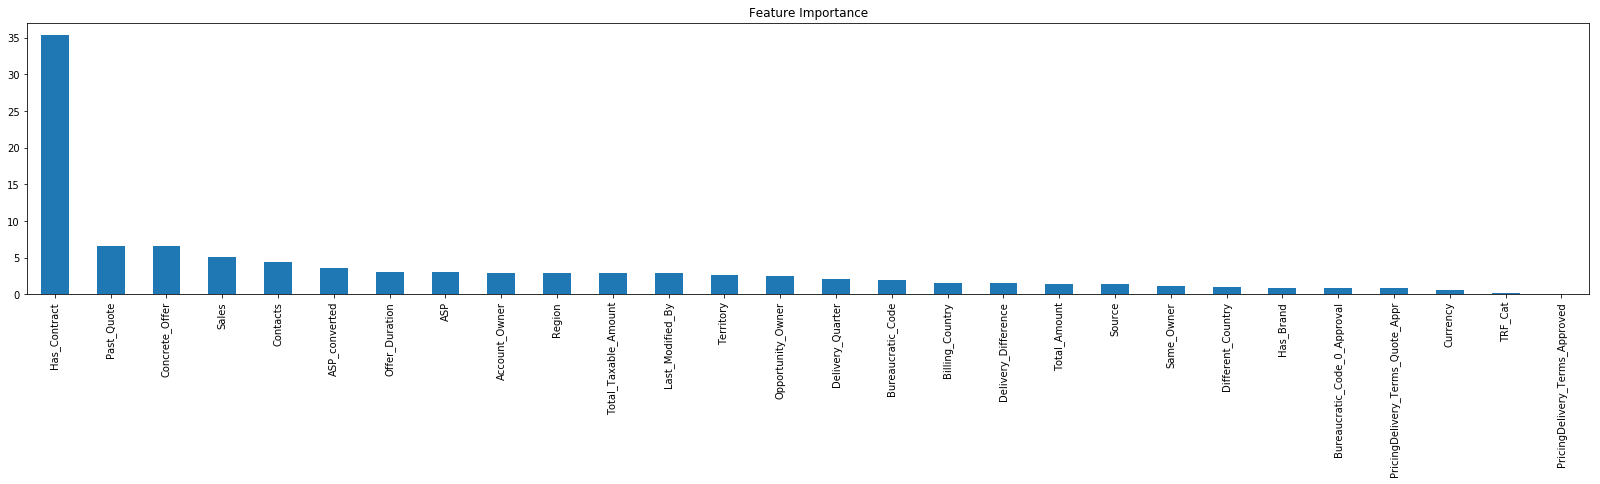

In [96]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(trainedmodel.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [97]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [98]:
bad

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales,Concrete_Offer,Offer_Duration,Territory_Defined,Past_Quote,Prediction
952,EMEA,Germany,1,0,0,0,Bureaucratic_Code_5,Source_7,Germany,511,1344,Person_Name_4,Person_Name_4,None,Person_Name_41,0.3875,0.43830,Q2,287525.00,287525.00,0,1,12.0,False,False,True,False,1.0,17,88.0,8.0,True,603.0,0.945039
10407,Americas,None,1,0,0,0,Bureaucratic_Code_5,Source_7,United States,6515,3390,Person_Name_33,Person_Name_33,None,Person_Name_47,0.4950,0.49500,Q1,285862.50,285862.50,0,1,30.0,False,False,True,False,1.0,73,89.0,NaN,False,NaN,0.604282
10629,EMEA,Hungary,0,0,0,0,Bureaucratic_Code_4,Source_3,Hungary,6613,3804,Person_Name_4,Person_Name_4,None,Person_Name_4,0.3750,0.42416,Q1,38671.88,38671.88,1,1,4.0,True,False,True,False,0.0,4,165.0,116.0,True,46.0,0.401915
7145,APAC,China (PRC),1,1,1,1,Bureaucratic_Code_4,None,China,4398,2178,Person_Name_65,Person_Name_19,None,Person_Name_47,0.2800,0.28000,Q2,103880.00,103880.00,0,1,15.0,False,False,True,True,0.0,215,32.0,46.0,True,223.0,0.891144
9399,Americas,Central US,0,0,0,0,Bureaucratic_Code_4,Source_13,United States,5930,2953,Person_Name_3,Person_Name_48,None,Person_Name_47,0.4250,0.42500,Q4,48386.25,48386.25,0,1,0.0,False,False,True,True,0.0,2,100.0,14.0,True,162.0,0.601696
1457,EMEA,Spain,1,1,0,0,Bureaucratic_Code_4,Source_11,Spain,833,1528,Person_Name_42,Person_Name_23,None,Person_Name_47,0.3750,0.42416,Q1,75937.50,75937.50,0,1,3.0,False,False,True,False,0.0,72,41.0,33.0,True,323.0,0.823686
8194,EMEA,Netherlands,0,0,0,0,Bureaucratic_Code_4,None,Netherlands,5126,2450,Person_Name_51,Person_Name_18,None,Person_Name_47,0.3750,0.42416,Q2,62109.38,62109.38,0,1,0.0,False,False,True,False,0.0,63,14.0,3.0,True,238.0,0.719162
12890,Americas,Central US,1,0,1,0,Bureaucratic_Code_5,None,United States,7819,4020,Person_Name_45,Person_Name_48,None,Person_Name_47,NaN,NaN,Q3,20000.00,668648.00,0,2,3.0,False,False,True,True,0.0,49,132.0,36.0,True,108.0,0.580892
1547,EMEA,Germany,1,1,1,1,Bureaucratic_Code_4,Source_9,Germany,897,1591,Person_Name_4,Person_Name_4,None,Person_Name_47,0.3900,0.44113,Q1,163995.00,163995.00,0,1,4.0,False,False,True,False,0.0,28,29.0,11.0,True,339.0,0.950773
13415,EMEA,Italy,1,0,0,0,Bureaucratic_Code_5,Source_11,Italy,8144,4306,Person_Name_2,Person_Name_2,None,Person_Name_2,0.3950,0.44678,Q2,88875.00,88875.00,0,1,4.0,True,False,True,False,0.0,55,32.0,19.0,True,17.0,0.647430


In [99]:
bad.Stage.value_counts()

0    17
1     1
Name: Stage, dtype: int64

In [155]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = trainedmodel.predict_proba(validation.drop(leak, axis = 1))[:,1]

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [156]:
prev = pd.read_csv("acceptable/submission_23.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9928448096853774

In [157]:
prev = pd.read_csv("acceptable/submission_11.csv")
prev["Prediction"].corr(answer["Prediction"])

0.9868558367660449

In [158]:
answer.to_csv("acceptable/submission_27.csv", header = False, index = False)

In [34]:
#p = prev.merge(answer, on = "Opportunity_ID")

In [35]:
#p["New_Prediction"] = (p.Prediction_x + p.Prediction_y) / 2.0

In [36]:
#pp = p[["Opportunity_ID", "New_Prediction"]]
#pp.to_csv("submission_24.csv", header = False, index = False)